# Prompt Enhancement Dataset: EDA

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer


/Users/jordan/miniconda3/envs/promptglow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jordan/miniconda3/envs/promptglow/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jordan/miniconda3/envs/promptglow/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <A09E200C-3620-3399-800F-6831D2DFDFC0> /Users/jordan/miniconda3/envs/promptglow/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/Users/jordan/miniconda3/envs/promptglow/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/jordan/miniconda3/envs/promptglow/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users

## Loading the Data

In [2]:
df = pd.read_csv("../data/prompts_raw.csv", index_col=0)

In [3]:
df.head()

,short_prompt,long_prompt
0,Skeleton doll sits behind window with dimly li...,A medium-close-up view of a white skeleton dol...
1,A light brown horse grazes beside a metal fenc...,A side view of a light brown horse that has it...
2,Prickly pear cactus grows alongside road and h...,A medium-close-up view of a prickly pear cactu...
3,"Snowy egret wades in shallow stream, legs lift...",A snowy egret is walking in a shallow stream o...
4,"Sky fills with cirrostratus clouds, sun sets b...",A view from below looking at the sky filled wi...


## Text Length & Alignment

I think it would be interesting to evaluate how the length compares across the short prompts and long prompts. 

In [4]:
# Get average prompt length in each column. 
short_lengths = [len(entry) for entry in df["short_prompt"]]
average_short_length = sum(short_lengths)/len(short_lengths)
average_short_length

69.37821229050279

In [5]:
# Get average prompt length in each column. 
long_lengths = [len(entry) for entry in df["long_prompt"]]
average_long_length = sum(long_lengths)/len(long_lengths)
average_long_length

582.0261949099938

In [6]:
average_long_length/average_short_length

8.389178326949592

Interesting, so on average the long prompts contain about 8 times more characters than the short prompts. 

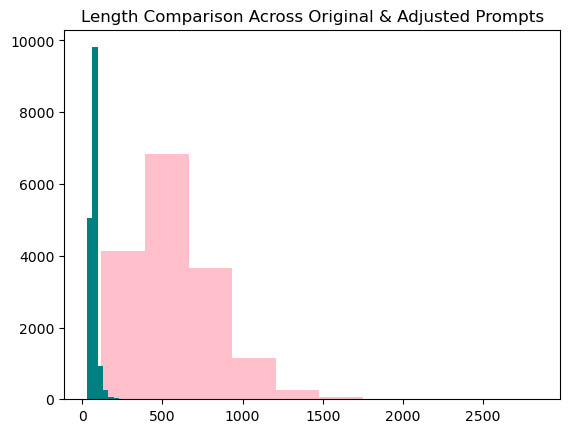

In [7]:
# Plot histogram of long lengths and histogram of short lengths
plt.hist(long_lengths, bins=10, color="pink")
plt.hist(short_lengths, bins=10, color="teal")
plt.title("Length Comparison Across Original & Adjusted Prompts")
plt.show()

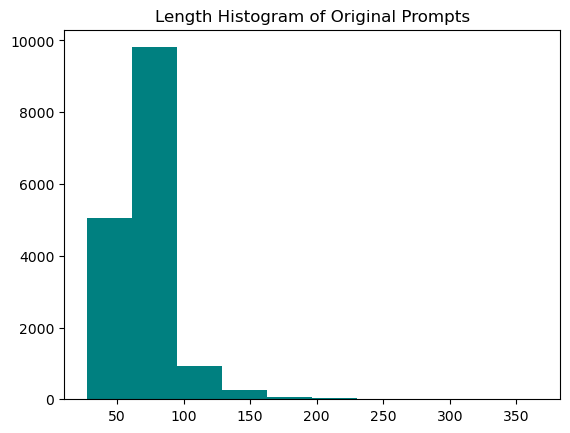

In [8]:
plt.hist(short_lengths, bins=10, color="teal")
plt.title("Length Histogram of Original Prompts")
plt.show()

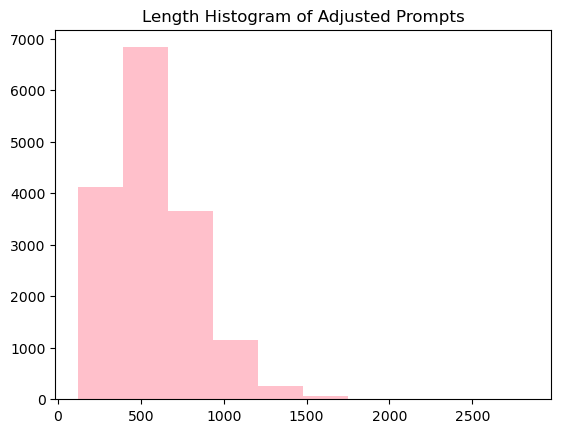

In [9]:
plt.hist(long_lengths, bins=10, color="pink")
plt.title("Length Histogram of Adjusted Prompts")
plt.show()

As we can see, the majority of long prompts are about 500 characters, and the majority of short prompts are around 75 characters long. 

Another interesting thing to investigate would be the alignment of the original text and the adjusted text. We can do this by computing the cosine similarity of their embeddings. 

In [10]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [11]:
# Let's encode the first short and long prompt
embeddings = model.encode([df.loc[0]["short_prompt"], df.loc[0]["long_prompt"]])

In [12]:
similarities = model.similarity(embeddings, embeddings)

In [13]:
similarities

tensor([[1.0000, 0.7967],
        [0.7967, 1.0000]])

Looking at the diagonal, we see that the two prompts are about 80% similar, which is pretty good!

Let's make a pipeline function to get these embeddings and similarities, and return just a single value for similarity. Then we can get the similarities for the whole dataset and plot them using a histogram or line chart.

In [14]:
similarities[0][1]

tensor(0.7967)

In [15]:
def pair_similarity(row : pd.Series) -> float:
    embeddings = model.encode([row["short_prompt"], row["long_prompt"]])
    similarities = model.similarity(embeddings, embeddings)
    return similarities[0][1] 

Now we can apply this to the dataframe, and add a new column for prompt similarity

In [16]:
df["prompt_similarity"] = df.apply(pair_similarity, axis=1)

In [17]:
df.head()

,short_prompt,long_prompt,prompt_similarity
0,Skeleton doll sits behind window with dimly li...,A medium-close-up view of a white skeleton dol...,tensor(0.7967)
1,A light brown horse grazes beside a metal fenc...,A side view of a light brown horse that has it...,tensor(0.6863)
2,Prickly pear cactus grows alongside road and h...,A medium-close-up view of a prickly pear cactu...,tensor(0.7563)
3,"Snowy egret wades in shallow stream, legs lift...",A snowy egret is walking in a shallow stream o...,tensor(0.6971)
4,"Sky fills with cirrostratus clouds, sun sets b...",A view from below looking at the sky filled wi...,tensor(0.7113)


In [18]:
type(df.loc[0]["prompt_similarity"])

torch.Tensor

In [19]:
df['prompt_similarity'] = df['prompt_similarity'].apply(lambda x: x.item())

In [20]:
type(df.loc[0]["prompt_similarity"])

numpy.float64

Text(0, 0.5, 'Similarity')

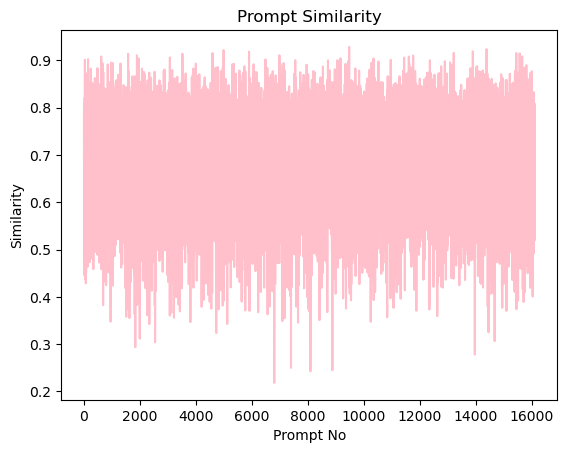

In [21]:
plt.plot(df["prompt_similarity"], color="pink")
plt.title("Prompt Similarity")
plt.xlabel("Prompt No")
plt.ylabel("Similarity")

We can see that the majority of the similarities are above 50%, with some exceptions. 

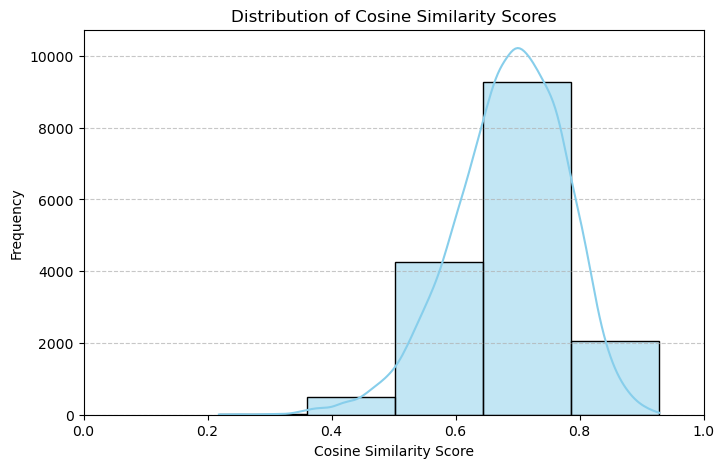

In [22]:
# Histogram (useful for more data points)
plt.figure(figsize=(8, 5))
sns.histplot(df['prompt_similarity'], bins=5, kde=True, color='skyblue') # Adjust bins as needed
plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.xlim(0, 1) # Cosine similarity ranges from -1 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

And now we can see that most prompt pairs have a similarity around 0.7 - 0.75. This seems pretty reasonable considering the longer prompt will include additional explanatory words that aren't directly related to the original. 

I'm curious to see also if a larger difference in prompt length corresponds to lower similarity. 

In [23]:
# Calculate the length of the short and long prompts
# Using word count for 'length' as it's often more relevant for prompts than character count
df['short_prompt_length'] = df['short_prompt'].apply(lambda x: len(x.split()))
df['long_prompt_length'] = df['long_prompt'].apply(lambda x: len(x.split()))

# Calculate the length gap
df['length_gap'] = df['long_prompt_length'] - df['short_prompt_length']

print("DataFrame with Lengths and Gaps:")
df.head()

DataFrame with Lengths and Gaps:


,short_prompt,long_prompt,prompt_similarity,short_prompt_length,long_prompt_length,length_gap
0,Skeleton doll sits behind window with dimly li...,A medium-close-up view of a white skeleton dol...,0.796653,9,102,93
1,A light brown horse grazes beside a metal fenc...,A side view of a light brown horse that has it...,0.686332,13,138,125
2,Prickly pear cactus grows alongside road and h...,A medium-close-up view of a prickly pear cactu...,0.756347,11,88,77
3,"Snowy egret wades in shallow stream, legs lift...",A snowy egret is walking in a shallow stream o...,0.697073,11,96,85
4,"Sky fills with cirrostratus clouds, sun sets b...",A view from below looking at the sky filled wi...,0.711336,11,48,37


In [ ]:
correlation = df['length_gap'].corr(df['prompt_similarity'])
print(f"\nPearson Correlation between Length Gap and Similarity Score: {correlation:.4f}")


Pearson Correlation between Length Gap and Similarity Score: -0.2935


A correlation coefficient of about -0.3 indeed indicates a weak negative correlation. This means there's a slight tendency for similarity to decrease as the length gap increases, but it's not a strong or consistent relationship.

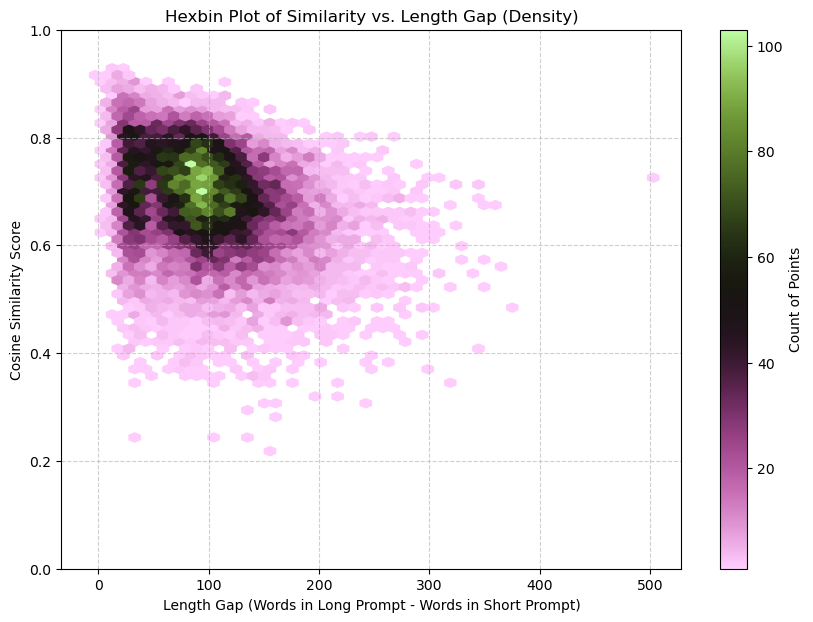

In [39]:
plt.figure(figsize=(10, 7))
plt.hexbin(df['length_gap'], df['prompt_similarity'], gridsize=50, cmap="vanimo", mincnt=1)
plt.colorbar(label='Count of Points')
plt.title('Hexbin Plot of Similarity vs. Length Gap (Density)')
plt.xlabel('Length Gap (Words in Long Prompt - Words in Short Prompt)')
plt.ylabel('Cosine Similarity Score')
plt.ylim(0, 1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

This results does align with our previous finding that a lower length gap is weakly correlated with a higher similarity. This does intuitively make sense as having a longer prompt implies more distinct words. But the graph does show that there are still a good number of instances with a higher word gap that maintain a high similarity, hence the *weak* correlation. There does seem to be one outlier with a length gap of 500, which could be interesting to see how that effects model performance later on. 